## Start

In [1]:
import torch
torch.cuda.set_device(4)

from rsnautils import *
from fastai2.callback.data import *

set_num_threads(1)
nw = 8
pre = 'tcia-ct-segm'

In [2]:
path = Path('~/data/tcia-ct-scan-dataset/nrrds').expanduser()

In [3]:
fns = get_image_files(path)

In [4]:
def get_lbl(fn):
    p = fn.parent.with_name('segmentations.dir')
    pkl = (p/fn.name).with_suffix('')
    return TensorMask(torch.load(pkl))

In [5]:
splits = RandomSplitter(0.1, seed=42)(fns)

In [7]:
def get_data(bs,sz):
    dsets = Datasets(fns, [[PILCTScan.create], [get_lbl]], splits=splits)
    nrm = Normalize(tensor(0.1),tensor(0.3))
    batch_tfms = L(Cuda(), nrm, IntToFloatTensor(), *aug_transforms(size=(sz,sz)))
    return dsets.dataloaders(bs, num_workers=8, after_item=ToTensor, after_batch=batch_tfms)

In [8]:
dls = get_data(16,256)
x,y = dls.one_batch()
x.mean((0,2,3)),x.std((0,2,3))

(tensor([-0.1773, -0.2171,  0.4359], device='cuda:4'),
 tensor([0.5735, 0.4578, 0.8072], device='cuda:4'))

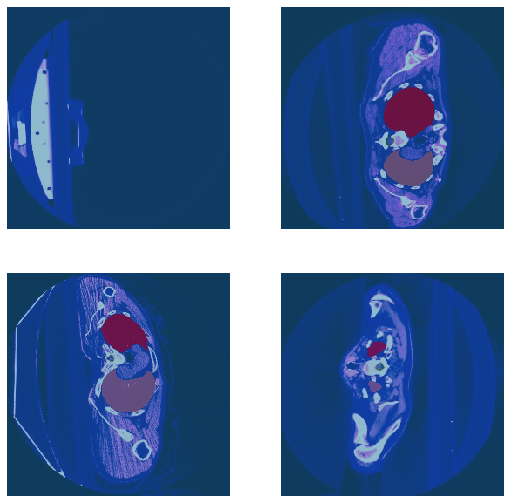

In [9]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(9, 9))

In [10]:
dls.c = 21

In [11]:
def acc(p,t): return accuracy(p.permute(0,2,3,1).contiguous(), t)

In [12]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)

learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func,
                     path=path, metrics=acc, wd_bn_bias=True,
                     config = unet_config(norm_type=None))

In [13]:
lr= 1e-3
learn.freeze()

In [14]:
learn.fit_one_cycle(3, lr, pct_start=0.9, wd=1e-2)

epoch,train_loss,valid_loss,acc,time
0,0.014335,0.010260,0.996486,03:16
1,0.008376,0.008430,0.997049,03:09
2,0.004845,0.004186,0.998296,03:09


In [15]:
learn.save('tcia-stage-1')

In [16]:
# learn.load('tcia-stage-1');

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(10, 1e-3, pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.004511,0.003996,0.998345,03:21
1,0.003876,0.004027,0.998336,03:22
2,0.004475,0.004021,0.998341,03:22
3,0.004170,0.003718,0.998451,03:22
4,0.005023,0.004303,0.998313,03:22
5,0.005687,0.004239,0.998258,03:21
6,0.004345,0.004296,0.998260,03:22
7,0.004065,0.003627,0.998497,03:22
8,0.003834,0.003480,0.998544,03:21
9,0.003176,0.003158,0.998649,03:21


In [19]:
learn.save('tcia-stage-2')

In [20]:
learn.dls = get_data(8,512)

In [21]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.8)

epoch,train_loss,valid_loss,acc,time
0,0.010113,0.008047,0.997348,13:31
1,0.005616,0.005055,0.998128,13:19
2,0.004798,0.003891,0.998462,13:19
3,0.003845,0.003463,0.998615,13:19
4,0.003678,0.003091,0.998750,13:19
5,0.003237,0.002922,0.998809,13:20
6,0.003442,0.002929,0.998804,13:20
7,0.003318,0.002752,0.998867,13:20
8,0.003003,0.002681,0.998888,13:22
9,0.002975,0.002596,0.998920,13:20


In [22]:
learn.save('tcia-stage-3')